# Advanced Lane Finding - Camera Calibration and Undistort

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 0. Dependencys

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

out_dir='output_images/'
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

## 1. Camera Calibration

In [2]:
def gen_obj_points (size):
    objp = np.zeros ((size[0] * size[1], 3), np.float32)
    objp [:, :2] = np.mgrid [0:size[0], 0:size[1]].T.reshape (-1, 2)
    return objp

obj_points = []
img_points = []

calibration_images = []
for file in glob.glob("camera_cal/calibration*.jpg"):
    img = cv2.imread (file)
    gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
    
    # there are not all chessboard corners detected on all images
    # sometime it detects smaller patterns
    # that's why I use different patterns to detect as much corners as possible
    
    pattern_size = (9, 6)
    found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (9, 5)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (8, 6)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if (not found):
        pattern_size = (7, 6)
        found, corners = cv2.findChessboardCorners(gray, pattern_size, None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)

    if (found):
        # saving corresponding object points
        obj_points.append (gen_obj_points (pattern_size))
        img_points.append (corners)
        cv2.drawChessboardCorners(img, pattern_size, corners, found) 
        image_name=os.path.split(file)[1]
        write_name = out_dir+'corners_found_ny'+ str(pattern_size) +'_'+image_name
        cv2.imwrite(write_name, img)
        print(file)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)


camera_cal/calibration16.jpg
camera_cal/calibration12.jpg
camera_cal/calibration10.jpg
camera_cal/calibration15.jpg
camera_cal/calibration1.jpg
camera_cal/calibration9.jpg
camera_cal/calibration14.jpg
camera_cal/calibration7.jpg
camera_cal/calibration17.jpg
camera_cal/calibration3.jpg
camera_cal/calibration18.jpg
camera_cal/calibration13.jpg
camera_cal/calibration8.jpg
camera_cal/calibration20.jpg
camera_cal/calibration5.jpg
camera_cal/calibration4.jpg
camera_cal/calibration2.jpg
camera_cal/calibration11.jpg
camera_cal/calibration19.jpg
camera_cal/calibration6.jpg


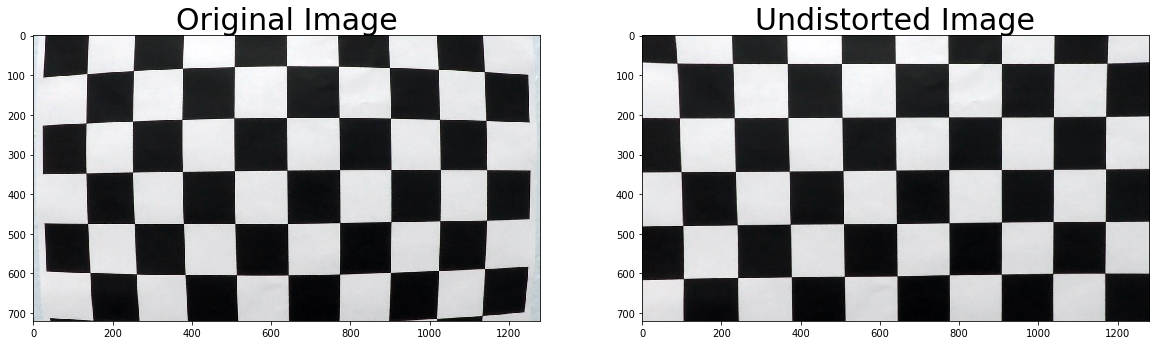

In [3]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')

img_undistort = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

In [5]:
# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

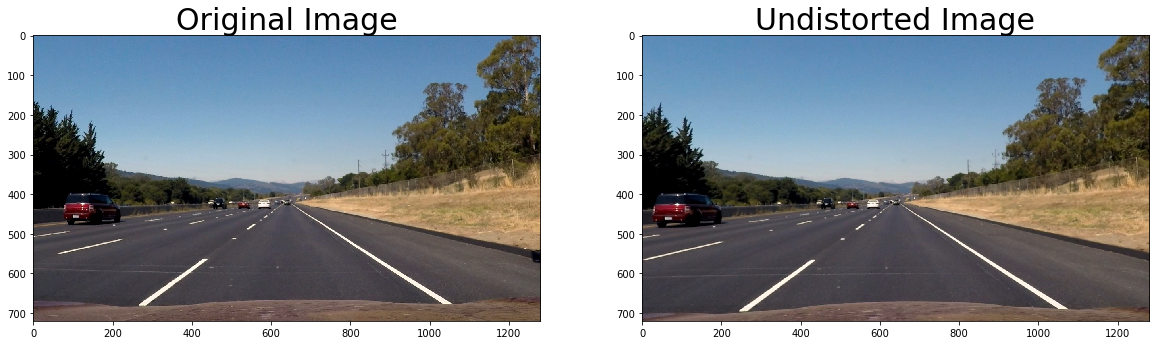

In [6]:
# Test undistortion on an image
img = cv2.cvtColor(cv2.imread ('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)

# Do camera calibration given object points and image points
img_undistort = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [7]:
# determine perspective transform matrix
undistort =  undistort(img, mtx, dist)

marked = cv2.circle (undistort, (285, 671), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (420, 577), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (880, 577), 10, (0, 0, 255), -1)
marked = cv2.circle (marked, (1000, 651), 10, (0, 0, 255), -1)

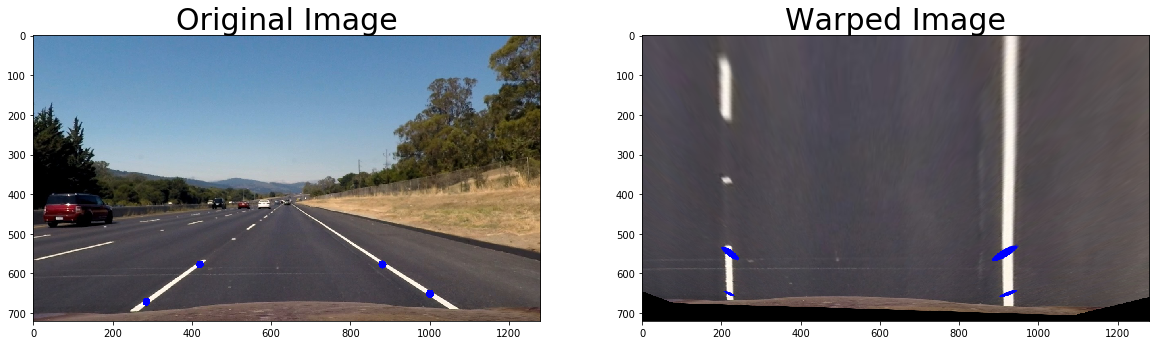

In [8]:
#handcrafted road points for perspective projection matrix calculation
src = np.float32 ([
        [285, 671],
        [418, 577],
        [885, 577],
        [1000, 651]
    ])

dst = np.float32 ([
        [220, 651],
        [220, 550],
        [921, 550],
        [921, 651]
    ])

# calculating front view -> top view projection matrix
M = cv2.getPerspectiveTransform (src, dst)
# calculating top -> front view matrix
M_inv = cv2.getPerspectiveTransform (dst, src)

def warp (image):
    img_size = (image.shape [1], image.shape [0])
    warped =  cv2.warpPerspective ( image, M, img_size, flags=cv2.INTER_LINEAR )
    return warped


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistort)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warp(undistort))
ax2.set_title('Warped Image', fontsize=30)